In [2]:
# Load the python libraries
import os, sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# some imports from dipy
from dipy.data import fetch_cenir_multib, read_cenir_multib, gradient_table
from dipy.segment.mask import median_otsu

# Import local modules

# Modify the module path (if required) so that we can import
# modules from this repository
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices
from freewater_runner import FreewaterRunner

### Loading Example data from dipy

Since we cannot find publicly available single shell data, we use multishell data from data and transform it to look like single shell data

In [3]:
# !! RUN THIS ONCE ONLY !!
# # Download eddy-current/motion corrected data (a couple of GB will be downloaded)
# fetch_cenir_multib(with_raw=False)

In [4]:
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/sld0465/.dipy/cenir_multib 


In [5]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### Process Single shell data

In [6]:
# we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(ss_data, 4, 2, False, vol_idx=[0], dilate=1)

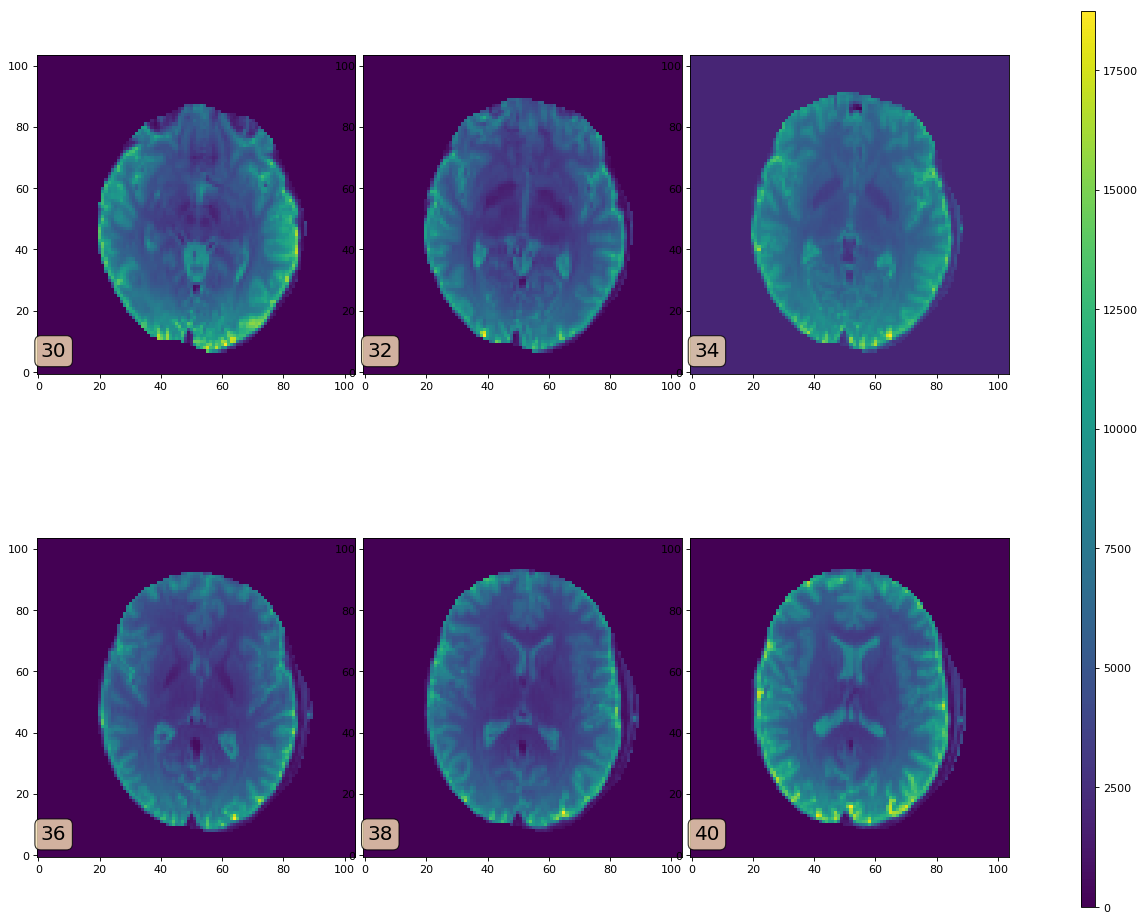

In [7]:
# plot the b0 image for a few z-axis slices
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

# Work with smaller data and get the freewater maps, FA, corrected-FA etc

In [8]:
fw_runner = FreewaterRunner(maskdata, ss_gtab, 
                                   xslice=slice(10, 90), 
                                   yslice=slice(10, 90), 
                                   zslice=slice(30, 41))
fw_runner.LOG = False # turn off logging for this example
fw_runner.run_model(num_iter=100, dt=0.001)

Stissue = 0.0001 : Swater = 16227.5042549
Single shell bvalue = 1000.0
Attenuation_min = 0.007, Attenuation_max = 0.990
Ahat.shape = (80, 80, 11, 183)
Awater_k = 0.05
f_init.shape = (80, 80, 11, 1)


#### Check for model convergence

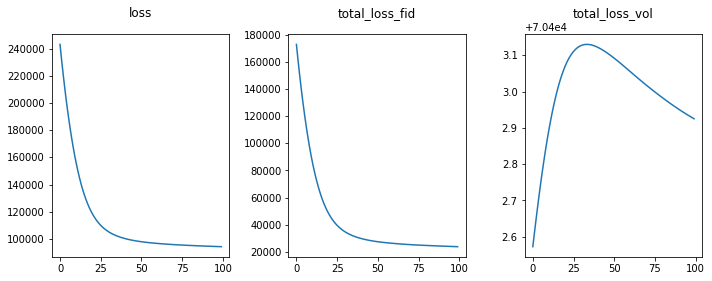

In [9]:
fw_runner.plot_loss()

#### Free Water map

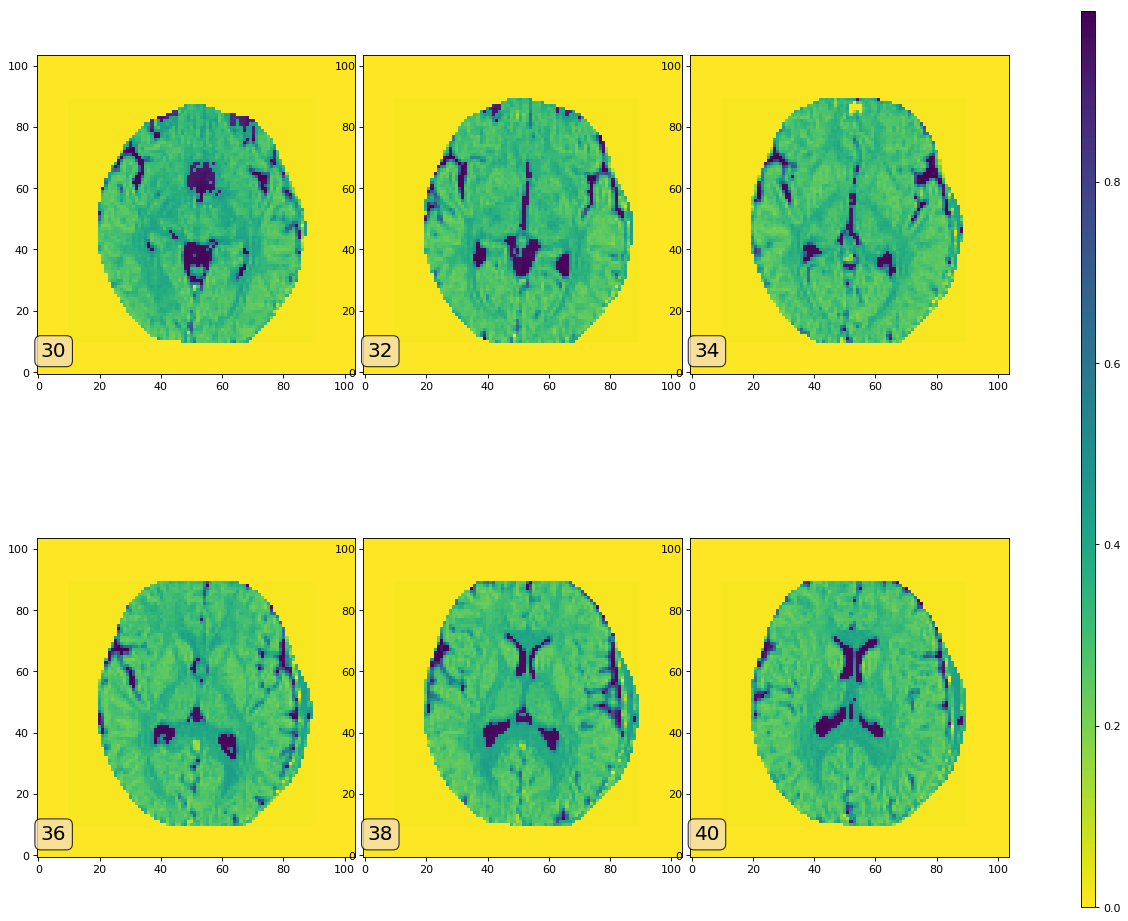

In [10]:
# Free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(fw_runner.get_fw_map(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

#### Mean Diffusivity (free water corrected)

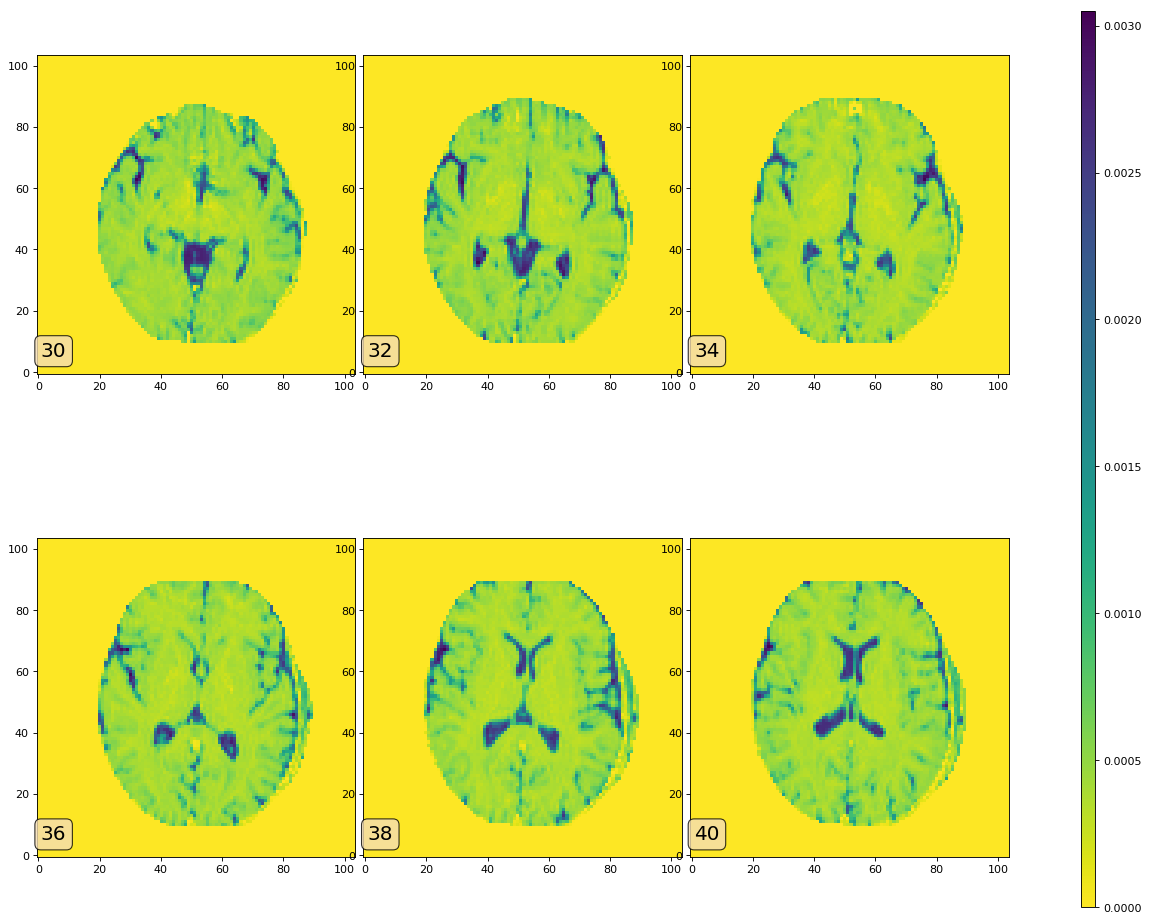

In [11]:
plt.set_cmap("viridis_r")
plot_3d_z_indices(fw_runner.get_fw_md(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

#### Fractional Anisotropy (free water corrected)

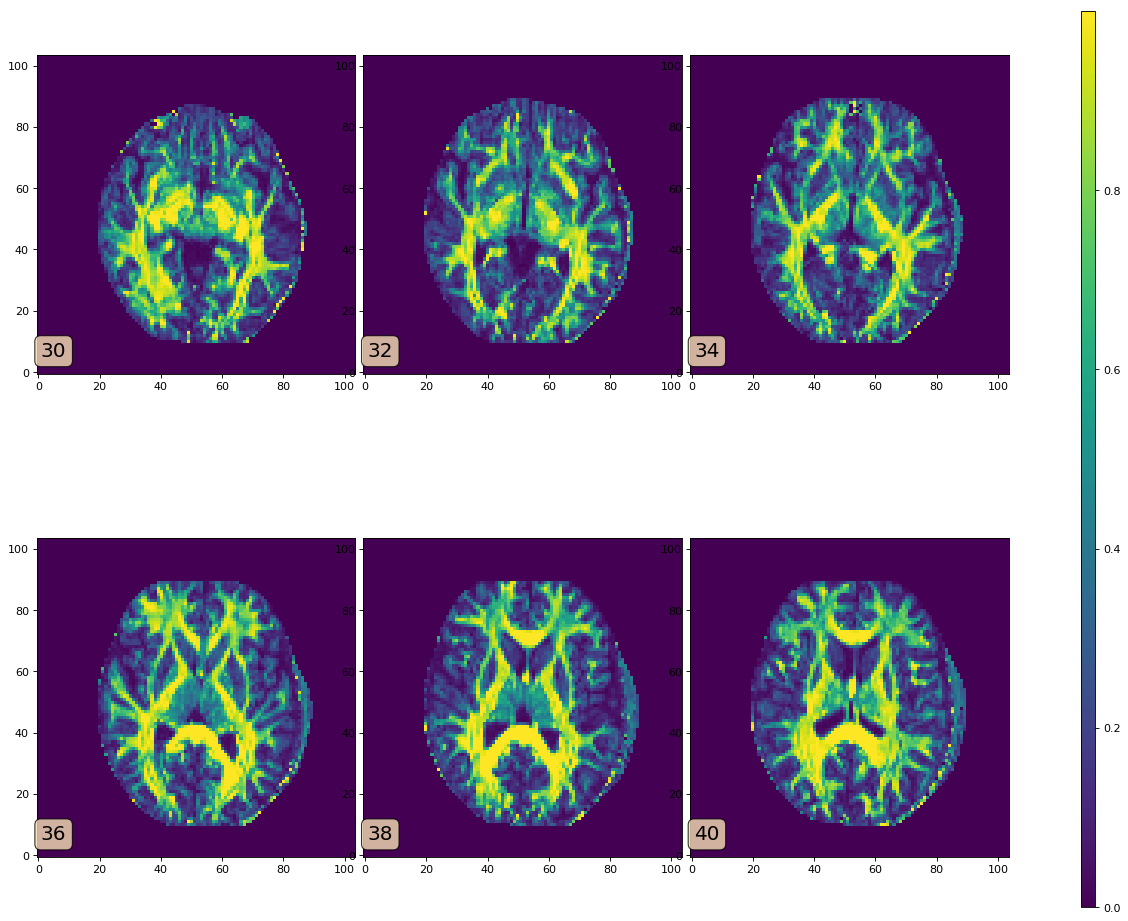

In [12]:
### Freewater corrected Fractional Anisotropy
plt.set_cmap("viridis")
plot_3d_z_indices(fw_runner.get_fw_fa(), idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)